In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import matplotlib.pyplot as plt
import pickle
import tqdm

import numpy as np
import pandas as pd
import torch
from pyspark.sql import functions as sf

from replay.data_preparator import DataPreparator
from replay.experiment import Experiment
from replay.session_handler import State
from replay.metrics import Coverage, HitRate, MRR, MAP, NDCG, Surprisal
from replay.models import DDPG, NeuroMF
from replay.models.ddpg import Actor_DRR, Env, State_Repr_Module, OUNoise
from replay.splitters import UserSplitter
from replay.utils import convert2spark
from rs_datasets import MovieLens

spark = State().session

22/06/09 18:34:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/09 18:34:56 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/06/09 18:34:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
/home/u19893556/miniconda3/envs/diploma/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: http

In [3]:
K = 10
K_list_metrics = [1, 3, 10]
SEED = 42

# Data reading & validation

In [4]:
data = MovieLens("1m").ratings
data["rating"] = data["rating"].apply(lambda x: 1 if x > 3 else -0.1)

preparator = DataPreparator()
log, _, _ = preparator(data, mapping={"relevance": "rating"})

In [5]:
user_random_splitter = UserSplitter(
    item_test_size=K,
    user_test_size=500,
    drop_cold_items=True,
    drop_cold_users=True,
    shuffle=True,
    seed=SEED
)
train, test = user_random_splitter.split(log)
train.count(), test.count()

22/06/09 18:35:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/06/09 18:35:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


(995209, 3090)

## Baseline

In [6]:
%%time
neuro_mf = NeuroMF()
neuro_mf.fit(train)

09-Jun-22 18:35:41, replay, INFO: The model is neural network with non-distributed training


KeyboardInterrupt: 

In [7]:
%%time
res_neuro_mf = Experiment(test, {NDCG(): K_list_metrics, HitRate(): K_list_metrics})
recs_neuro_mf = neuro_mf.predict(
    k=K,
    users=test.select('user_idx').distinct(),
    log=train,
    filter_seen_items=True
)
res_neuro_mf.add_result(name, recs_neuro_mf)
res_neuro_mf.results

NameError: name 'NDCG' is not defined

## RL

In [ ]:
%%time

ddpg = DDPG(log_dir='logs/ou/04')
ddpg.fit(train)

In [8]:
ddpg = DDPG(writer=False)

log = train
users = log.select("user_idx").distinct()
items = log.select("item_idx").distinct()
ddpg.fit_users = users.cache()
ddpg.fit_items = items.cache()
ddpg._num_users = ddpg.fit_users.count()
ddpg._num_items = ddpg.fit_items.count()
ddpg._user_dim_size = (
    ddpg.fit_users.agg({"user_idx": "max"}).collect()[0][0] + 1
)
ddpg._item_dim_size = (
    ddpg.fit_items.agg({"item_idx": "max"}).collect()[0][0] + 1
)

09-Jun-22 18:38:00, replay, INFO: The model is neural network with non-distributed training
22/06/09 18:38:00 WARN CacheManager: Asked to cache already cached data.
22/06/09 18:38:00 WARN CacheManager: Asked to cache already cached data.


In [13]:
def eval_single(logdir, step, res=None, milestone='reset_fixed', name=''):
    ddpg.state_repr.load_state_dict(torch.load(f'data/logs/{milestone}/{logdir}/state_repr_{step}0000.pth'))
    ddpg.policy_net.load_state_dict(torch.load(f'data/logs/{milestone}/{logdir}/policy_net_{step}0000.pth'))
    with open(f'data/logs/{milestone}/{logdir}/memory.pickle', 'rb') as f:
        ddpg.train_env.memory = pickle.load(f)

    recs = ddpg.predict(
        k=K,
        users=test.select('user_idx').distinct(),
        log=train,
        filter_seen_items=True
    )

    if not name:
        name = step
    if not res:
        res = Experiment(test, {NDCG(): K_list_metrics, HitRate(): K_list_metrics})
    res.add_result(name, recs)
    del recs; gc.collect()

In [19]:
def eval_single(logdir, step, res=None, milestone='ou', name=''):
    ddpg.state_repr.load_state_dict(torch.load(f'logs/{milestone}/{logdir}/state_repr_{step}0000.pth'))
    ddpg.policy_net.load_state_dict(torch.load(f'logs/{milestone}/{logdir}/policy_net_{step}0000.pth'))
    with open(f'logs/{milestone}/{logdir}/memory.pickle', 'rb') as f:
        ddpg.train_env.memory = pickle.load(f)

    recs = ddpg.predict(
        k=K,
        users=test.select('user_idx').distinct(),
        log=train,
        filter_seen_items=True
    )

    if not name:
        name = step
    if not res:
        res = Experiment(test, {NDCG(): K_list_metrics, HitRate(): K_list_metrics})
    res.add_result(name, recs)
    del recs; gc.collect()

### learning curves

In [14]:
reset_fixed = Experiment(test, {NDCG(): K_list_metrics, HitRate(): K_list_metrics})
for i in tqdm.tqdm(range(1, 100)):
    try:
        eval_single('true', i, reset_fixed)
    except Exception as e:
        print(e)
        break

  0%|                                                                                                                                  | 0/99 [00:00<?, ?it/s]

[Errno 2] No such file or directory: 'data/logs/reset_fixed/true/memory.pickle'


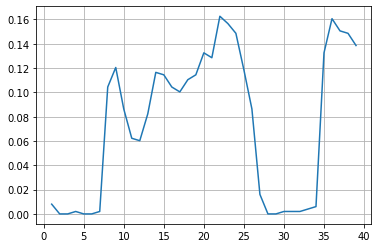

In [61]:
reset_fixed.results['HitRate@10'].plot(grid=True);

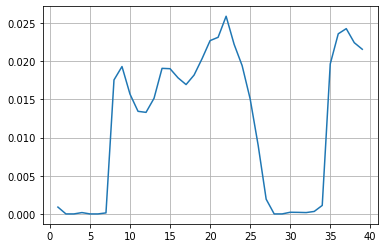

In [62]:
reset_fixed.results['NDCG@10'].plot(grid=True);